# Operations for basic photometry using AutoPhOT


This notebook describes how to use the AutoPhOT code to perform photometry on a single transient. The code used here can be installed by running '<font  color='blue'>conda install -c astro-sean autophot</font>' in a Python3 enviroment.

This notebook will use pre-packaged fits images for demonstration purposes. We will descirbe how to use your own data.

In [1]:
import autophot

AutoPhOT requires input instructions
* Many of these are initial guesses and will be changed during image analysis


Items in **bold** are parameters in the syntax dictionary that can be updated.

In [2]:
# Load default input yaml file
from autophot.prep_input import load
syntax = load()

Default input loaded in from: 
/Users/seanbrennan/Documents/autophot_development/AutoPHoT_conda/autophot/autophot/databases/default_input.yml


We will now use a pre-packaged fits image for the purpose of demonstration. **You can ignore/delete the following 2 cells if you are using your own data!**

In [3]:
# Built in function to move some example data onto the users desktop
from autophot.example import save_example_data
fpath = save_example_data.save_fits_to_desktop()

Successful copy of example.fits written to:
/Users/seanbrennan/Desktop/autophot_example/example.fits


Example fits file should now be available on your desktop in a folder called *autophot_example*.

We can now tell AutoPhoT that we want to work on this folder by updating **fits_dir**.

In [4]:
# Lets get the parent dictionary of this new example image
import os
dirpath = os.path.dirname(fpath)

print('We are looking for fits images in the folder: %s' % dirpath)

We are looking for fits images in the folder: /Users/seanbrennan/Desktop/autophot_example


If you are using your own data update dirpath to where you have your own fits images. AutoPhOT will look though (using os.walk) the folder searching for images that end with .fits,.fts or .fit 

For example:
    dirpath = '/Users/******/Desktop/SN1987A'



Now tell AutoPhot where to look for files by updating **fits_dir**.

In [5]:
syntax['fits_dir'] = dirpath

   <h3 align="center">AutoPhOT accounts for unique keywords found in different headers</h3> 


AutoPhOT will build a database of telescope information that is saved to the users local machine.

*telescope.yml* will be created and keeps track of different file naming conventions e.g. Filter header keys, Gain key etc. This file is stored in **wdir**. 

We will set this to the same directory as example.fits.

In [6]:
print('Setting work directory (wdir) to: %s' % dirpath)
# set working directory
syntax['wdir'] = dirpath

Setting work directory (wdir) to: /Users/seanbrennan/Desktop/autophot_example


If you plan on reusing AutoPhOT on many different transients, it may be convenient to save the database to a more accesable location for example 

syntax['wdir'] = /Users/******/Desktop/AutoPhoT_database

   <h3 align="center">Catalog Selection</h3> 

The current version of the code needs additional information to get started:


* Catalog version:
    * Currently available:
        - Pan-STARRS,
        - APASS,
        - 2MASS
        - Skymapper
        - SDSS
    
* What transient you want to observe:
     - Update **target_name** to check TNS
     - **target_ra/target_dec** to observed specific source in the field
    
First we'll look at the example fits files using some packages from autophot

In [7]:
# Options are skymapper, 2mass, pan_starrs, sdss, apass 
syntax['catalog'] = 'skymapper'

   <h3 align="center">Where are we looking?</h3> 

Need to tell AutoPhOT where to look. Target photometry has several options:

* **target_name** give the TNS IAU name ignore SN/AT e.g. SN 1987A => 1987A

* **target_ra**/**target_dec** give ra/dec (in ICRS) in degrees (all coords in AutoPhOT use degrees)

* leave both **target_name** and **target_ra**/**target_dec** blank (i.e. null \ None) to perform calibration on image (astrometry, fwhm, zeropint etc) only


In [8]:
# Select a source 
ra = 114.070433
dec = -69.529716

# This source is not a transient although it is close to the center of the galaxy (NGC 2442)
# In this case this source isn't in TNS so we leave target_name as None and update target_ra and target_dec

syntax['target_ra'] = ra
syntax['target_dec'] = dec

# If we know the IAU name we can update target_name (leave out the prefix i.e. SN or AT)
# for example: syntax['target_name'] = 1987A

print('Performing photometry on source at ra/dec = %.6f/%.6f' %  (ra,dec))

Performing photometry on source at ra/dec = 114.070433/-69.529716


**Checking SkyMapper catalog, source at 114.070433 -69.529716 has r =  17.401 +/- 0.01 mag**

<h3 align="center">Lets display the image (not required)</h3> 

** This cell uses the **fpath** previously defined ** if you are using your own data ignore this cell

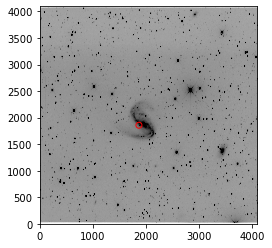

In [9]:
if fpath:
    # autophot functions to find image data and header from fits files
    from autophot.packages.functions import getimage
    from autophot.packages.functions import getheader

    # image
    data = getimage(fpath)

    # header
    header = getheader(fpath)


    # We will plot out the image 
    import matplotlib.pyplot as plt
    from astropy.visualization import ImageNormalize,SquaredStretch,ZScaleInterval

    # Create an ImageNormalize object
    vmin,vmax = (ZScaleInterval(nsamples = 1000)).get_limits(data)

    plt.imshow(data,
              vmin = vmin,
              vmax = vmax,

              origin = 'lower',
              cmap = 'Greys')

    '''
    For purpose of this example WCS is already in header. 
    AutoPhOT is able to call astrometry.net from a local instance although for this example we assume the user doesn't
    have astrometry installed
    ''' 

    from astropy import wcs
    w = wcs.WCS(header)



    # Choose a source in image
    from astropy.coordinates import SkyCoord 
    c = SkyCoord(ra,dec , unit="deg") 

    x_pix,y_pix = w.all_world2pix(c.ra.degree, c.dec.degree, 1)

    plt.scatter(x_pix,y_pix,marker = 'o',facecolor = 'none',edgecolor = 'r')

    plt.show()

<h3 align="center">Ready to go!</h3> 

Input is now ready to run!

For this demonstration, example.fits has trusted wcs already in the header. AutoPhOT will detect wcs keywords (CRVAL1, CRVAL2, etc) and skip over this step. If the user wants to force new astrometry, regardless of what is already written, set **remove_wcs** to True.

**AutoPHoT relies on a user side dictionary of telescope data.**

Before starting, AutoPhOT will run through all files and ensure all keywords are known. It will ask the user to clariy any non-standard keywords. This may take away from the automation side of things but such steps only need to be taken once and it allows smoother operations if working with many files. For the purpose of this example there is no need in input scale_type or scale_units as we will not be needed for input into astrometry.net so user can type *skip*. You'll see that if you rerun the script it won't ask you for this parameters as it check the pre-existing keys beforehand.

***We recommend you familirise yourself with this  example on how telescope.yml works see [here](https://github.com/Astro-Sean/autophot/blob/master/example_notebooks/example_call_database.ipynb) ***

This script (*write_yaml.yml*) is still underdevelopment as it needs to be be broad enough to accept various file structures and thusly, might fail. We hope to minimise these failures but as a backup, one can manually update the *telescope.yml* file.

To allow for a batch of files to be run, terminated and restarted from the same instance we have **restart** keyword that is defaulted to True. Leaving this command on will ignore any files that have already been ran through by the code. (i.e. it will look for the out.csv file in the output folders)

In [10]:
from autophot.autophot import run_automatic_autophot

run_automatic_autophot(syntax)


    _       _       ___ _  _    _____
   /_\ _  _| |_ ___| _ \ || |__|_   _|
  / _ \ || |  _/ _ \  _/ __ / _ \| |
 /_/ \_\_,_|\__\___/_| |_||_\___/|_|

 ---------------------------------------
         AutoPhOT Beta
         S.J.Brennan et al. 2020 in prep
         Please provide feedback/bugs to:
         Email: sean.brennan2@ucdconnect.ie
---------------------------------------



AutoPhOT Version: 0.1.1
Checking internet connection...
Connected to internet

Directory of fits file: /Users/seanbrennan/Desktop/autophot_example

Restarting - checking for files already completed in:
/Users/seanbrennan/Desktop/autophot_example_REDUCED

Total Files: 1

Files already done: 0
- EXAMPLE_TELESCOPE

Adding new insturment: EXAMPLE_TELESCOPE

 *** Instrument Found ***
EXAMPLE_TELESCOPE -> INSTRUME -> EXAMPLE_INSTRUMENT
Simplified name [default: EXAMPLE_INSTRUMENT]: Example

Instrument pixel scale
Accepted scale units
Scale units [type skip to ignore]: skip

Similar gain keywords found
File: exam

File: example_APT.fits - PID: 48474
Start Time: 2021-02-19 13:05:39.031894
Telescope: EXAMPLE_TELESCOPE
Filter: r
MJD: 58849.000
Observation Date: 2020-01-01
Gain keyword not found - check telescope.yml - SETTING TO 1
Exposure time: 60s 
Detecting/removing cosmic ray sources


Starting Astroscrappy ... working ... this may take some time ... done
Exposure time: 60s :: Cosmic Ray Detections: 4048


Cosmic rays removed - image updated
WCS found
Using Gaussian Profile for fitting
Number of sources before cleaning - [s = 100.0]: 521 
Too many sources
Number of sources before cleaning - [s = 200.0]: 332 


-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source


Isolated sources found [ 200 sigma ]: 295

Image FWHM: 4.617 +/- 0.153 

sigma:1.961

sigma_err:0.064

Aperture correction: -0.094 +/- 0.009
Searching for viable sources
New target name: target_ra_114_dec_-70
Searching for new catalog: skymapper 
Catalog length: 1426
Using Gaussian Profile for fitting


Matching catalog source to image: 251 / 771 

Average pixel offset: 2.131 
Using PSF Photometry
SNR: 7538 FWHM: 4.617


Residual table updated: 1 / 12 

SNR: 7510 FWHM: 4.617


Residual table updated: 2 / 12 

SNR: 7121 FWHM: 4.617


Residual table updated: 3 / 12 

SNR: 6599 FWHM: 4.617


Residual table updated: 4 / 12 

SNR: 6487 FWHM: 4.617


Residual table updated: 5 / 12 

SNR: 6303 FWHM: 4.617


Residual table updated: 6 / 12 

SNR: 6098 FWHM: 4.617


Residual table updated: 7 / 12 

SNR: 5735 FWHM: 4.617


Residual table updated: 8 / 12 

SNR: 5690 FWHM: 4.617


Residual table updated: 9 / 12 

SNR: 5676 FWHM: 4.617


Residual table updated: 10 / 12 

SNR: 5548 FWHM: 4.617


Residual table updated: 11 / 12 

SNR: 5535 FWHM: 4.617
Image_radius [pix] : 8.541 +/- 0.110
FWHM of PSF model: 4.617
Approx PSF mag -10.133
Image cutout size: (14,14) (14,14)
Fitting PSF to 250 sources


Residual table updated: 12 / 12   
Fitting PSF to source: 249 / 250


r-band zeropoint: 22.974 +/- 0.033 



Fitting PSF to source: 250 / 250  


Approx. limiting magnitude: 17.863 
Target photometry on original image
Fitting PSF to Target
Fitting PSF to 1 sources
Fitting gaussian to source to get FWHM
Target FWHM: 4.642
Image 1 / 1 saved
SNR = 67 - skipping limiting magnitude
Pixel Offset: 1.222

Target counts: 158.040 +/- 2.365
Target SNR: 66.830 +/- 0.016
Instrumental Magnitude: -5.497 +/- 0.016
Zeropoint: 22.974 +/- 0.033
Limiting Magnitude: skipped
Target Magnitude: 17.477 +/- 0.046 

*** Transient well detected ***

Time Taken [ 48474 ]: 77s
Sucess: example_APT.fits :: PID 48474 




---

Total failure : []

DONE
Recovering Output...
Data recovered :: Output File:
/Users/seanbrennan/Desktop/autophot_example_REDUCED/REDUCED.csv

Done - Time Taken: 104.7


<h3 align="center">Looking at the outputs!</h3> 


Output of AutoPhOT will be given in folder in the parent dictionary of the fits_folder, below we display some of the visual outputs

For example if the **fits_dir** is set to */Users/seanbrennan/Desktop/autophot_example* the ouput folder will be */Users/seanbrennan/Desktop/autophot_example_REDUCED*


**The following is for illistrative purposes and is not needed for AutoPhOT**

Each image will have a *out.csv*. Once AutoPhOT has completed each file in a folder it will collect all these files into one file named *REDUCED.csv* in the output folder

In [11]:
import pandas as pd

output_data = pd.read_csv('/Users/seanbrennan/Desktop/autophot_example_REDUCED/REDUCED.csv')

print(output_data.T)

                                                              0
fname         /Users/seanbrennan/Desktop/autophot_example_RE...
telescope                                               Example
TELESCOP                                      EXAMPLE_TELESCOPE
INSTRUME                                               INSTRUME
instrument                                   EXAMPLE_INSTRUMENT
mjd                                                     58849.0
lmag                                                        NaN
method                                                      psf
subtraction                                               False
xpix                                                1867.754125
ypix                                                1856.492447
r_inst                                                -5.496918
r_inst_err                                             0.032252
zp_r                                                  22.974274
zp_r_err                                

/Users/seanbrennan/anaconda2/envs/conda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


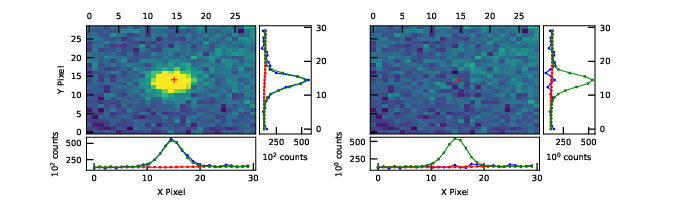

In [1]:
# Wand is used to display pdf images in jupyter notebooks - it is not needed for AutoPhoT
from wand.image import Image as WImage
PSF = WImage(filename = "/Users/seanbrennan/Desktop/autophot_example_REDUCED/example/target_psf_example_APT.pdf",
             resolution = 100)
PSF

Zeropint calibration from skymapper with some gentle sigma clipping

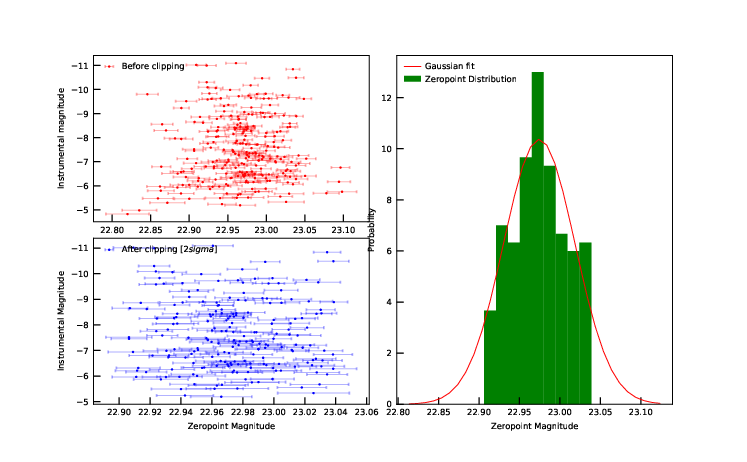

In [2]:
ZP = WImage(filename = "/Users/seanbrennan/Desktop/autophot_example_REDUCED/example/zp_example_APT.pdf",
            resolution = 100)
ZP

Magnitude recovery from PSF fitting in comparision to values from skymapper. We see the magnitude from the catalog minus the magnitude from the PSF fitting is fitted well

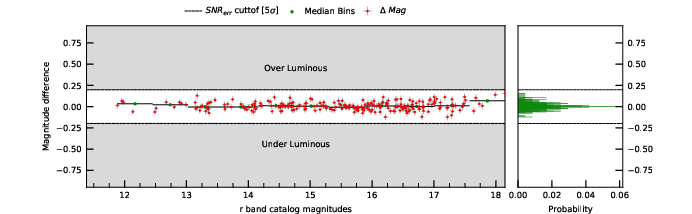

In [3]:
MAG_LIM= WImage(filename = "/Users/seanbrennan/Desktop/autophot_example_REDUCED/example/mag_lim_example_APT.pdf",
                resolution = 100)
MAG_LIM

Output image showing stars using for zeropoint (blue), PSF stars (Yellow) and tagrget (green)

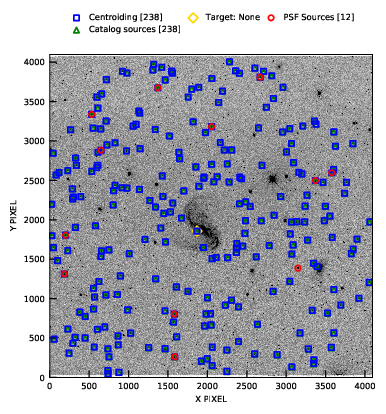

In [4]:
SOURCE_CHECK= WImage(filename = "/Users/seanbrennan/Desktop/autophot_example_REDUCED/example/source_check_example_APT.pdf",
                     resolution = 100)
SOURCE_CHECK